In [1]:
import numpy as np
import pandas as pd
import os
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf

!pip install python_speech_features

from python_speech_features import logfbank, mfcc, delta
import seaborn as sns
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(1234)
random.seed(1234)
tf.random.set_seed(1234)
!apt-get install tarfile
import tarfile
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import contextlib
import lzma
import tarfile
import matplotlib.pyplot as plt

!pip install visualkeras
import visualkeras

drive.mount('/content/drive')

os.chdir('drive/MyDrive/HDA')

from utilis import *

!tar -xf "speech_recognition.tar.xz" -C "/content"

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=b9ff0c09d37a883535d8bab56f0d5c0708bdc0d503005082a4d2deb4f2c2e9fb
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package tarfile
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 7.2 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
%cd ..
%cd ..
%cd ..
%cd ..

/content/drive/MyDrive
/content/drive
/content
/


**Preliminary Notes**

The structure of this notebook is slightly different from the others: the CNN_trad_fpool3 model is trained and tested here for all types of features.
The general structure is this:
*  Training and testing of model for each feature extraction method (MFCC, MFCC unique and log FIlterbanks)

* Training and testing of model for each feature extraction methods augmented with noise

NB: in order to prevent ram issues I suggest to run he model for each features with a new colab session and not all at once


In [3]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, losses
import keras


def cnn_trad_fpool3(input_shape, output_shape):
    X_input=keras.Input(input_shape)

    X=tf.keras.layers.Conv2D(filters=64, kernel_size=(8,20),padding='same', activation='relu')(X_input)
    X=tf.keras.layers.MaxPool2D((3,1))(X)

    X=tf.keras.layers.Conv2D(filters=64, kernel_size=(4,10) ,padding='same', activation='relu')(X)
    X=tf.keras.layers.MaxPool2D((1,1))(X)

    X=tf.keras.layers.Flatten()(X)
    X=tf.keras.layers.Dense(32, activation='relu')(X)
    X=tf.keras.layers.Dense(128, activation='relu')(X)
    X=tf.keras.layers.Dense(128, activation='relu')(X)

    X_final=tf.keras.layers.Dense(output_shape, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X_final)

    return model



In [4]:
# Garbage Collector - use it like gc.collect()
import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import EarlyStopping, Callback

class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
clear_memory = ClearMemory()

callbacks = [early_stopping, clear_memory]

**Model trained with MFCC**

In [ ]:
df=pd.DataFrame([(k, i) for k, v in browse_directory().items() for i in v],columns=['key_id', 'ids'])

#train_mask, validation_mask = split(df, 0.6, 0.2)

#df.to_csv("content/drive/MyDrive/HDA/training_validation_test.csv")

train_mask=list(np.loadtxt("content/drive/MyDrive/HDA/training_mask.txt"))
validation_mask=list(np.loadtxt("content/drive/MyDrive/HDA/validation_mask.txt"))

batch_size=128
out_class=len(label_list)

train_set, train_label_set = create_dataset(df['ids'].iloc[train_mask], df['key_id'].iloc[train_mask], batch_size,shuffle=True, cache_file_value='train_cache', type='mfcc')
validation_set, validation_label_set = create_dataset(df['ids'].iloc[validation_mask], df['key_id'].iloc[validation_mask], batch_size, shuffle=True , cache_file_value='validation_cache', type='mfcc')
test_set, test_label_test = create_dataset(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)], df['key_id'].iloc[~df.index.isin(train_mask+validation_mask)], batch_size, cache_file_value='test_cache', repeat=False, type='mfcc', testing=True)

train_steps = int(np.ceil(len(df['ids'].iloc[train_mask]) / batch_size))
validation_steps = int(np.ceil(len(df['ids'].iloc[validation_mask]) / batch_size))
test_steps = int(np.ceil(len(df['ids'].iloc[train_mask]) / batch_size))



/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Shuffled dataset
Shuffled dataset


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 39, 99, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 39, 99, 64)        10304     
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 99, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 99, 64)        163904    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 99, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 82368)             0     

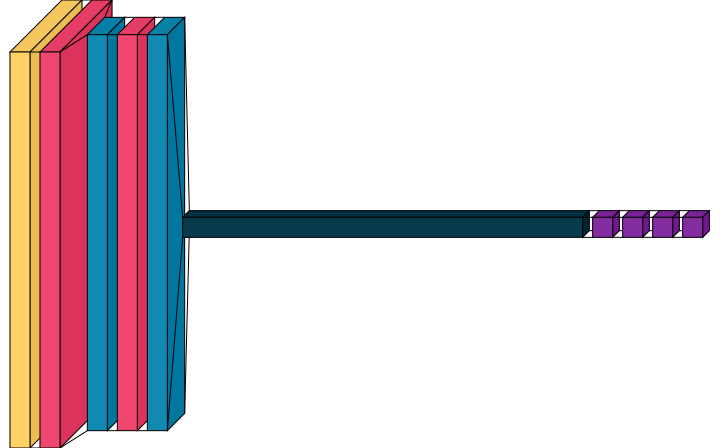

In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(39,99,1)

cnn_trad_fpool3_m = cnn_trad_fpool3(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(cnn_trad_fpool3_m.summary())
visualkeras.layered_view(cnn_trad_fpool3_m)

In [ ]:
cnn_trad_fpool3_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_cnn_trad_fpool3=cnn_trad_fpool3_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 46s 91ms/step - loss: 2.2865 - sparse_categorical_accuracy: 0.3461 - val_loss: 1.7417 - val_sparse_categorical_accuracy: 0.4878
Epoch 2/25
497/497 [==============================] - 50s 101ms/step - loss: 1.5837 - sparse_categorical_accuracy: 0.5313 - val_loss: 1.4875 - val_sparse_categorical_accuracy: 0.5557
Epoch 3/25
497/497 [==============================] - 45s 90ms/step - loss: 1.4085 - sparse_categorical_accuracy: 0.5798 - val_loss: 1.5312 - val_sparse_categorical_accuracy: 0.5733
Epoch 4/25
497/497 [==============================] - 50s 101ms/step - loss: 1.3187 - sparse_categorical_accuracy: 0.6059 - val_loss: 1.3457 - val_sparse_categorical_accuracy: 0.5971
Epoch 5/25
497/497 [==============================] - 45s 91ms/step - loss: 1.2227 - sparse_categorical_accuracy: 0.6347 - val_loss: 1.2661 - val_sparse_categorical_accuracy: 0.6241
Epoch 6/25
497/497 [==============================] - 45s 91ms/step - loss: 1.1716 - spa

In [ ]:
cnn_trad_fpool3_m.save("content/drive/MyDrive/HDA/models/mfcc_models/normal_dataset/{}".format('cnn_trad_fpool3_mfcc'))
#base_CNN_trad_fpool3=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/{}".format('cnn_fstride8'))

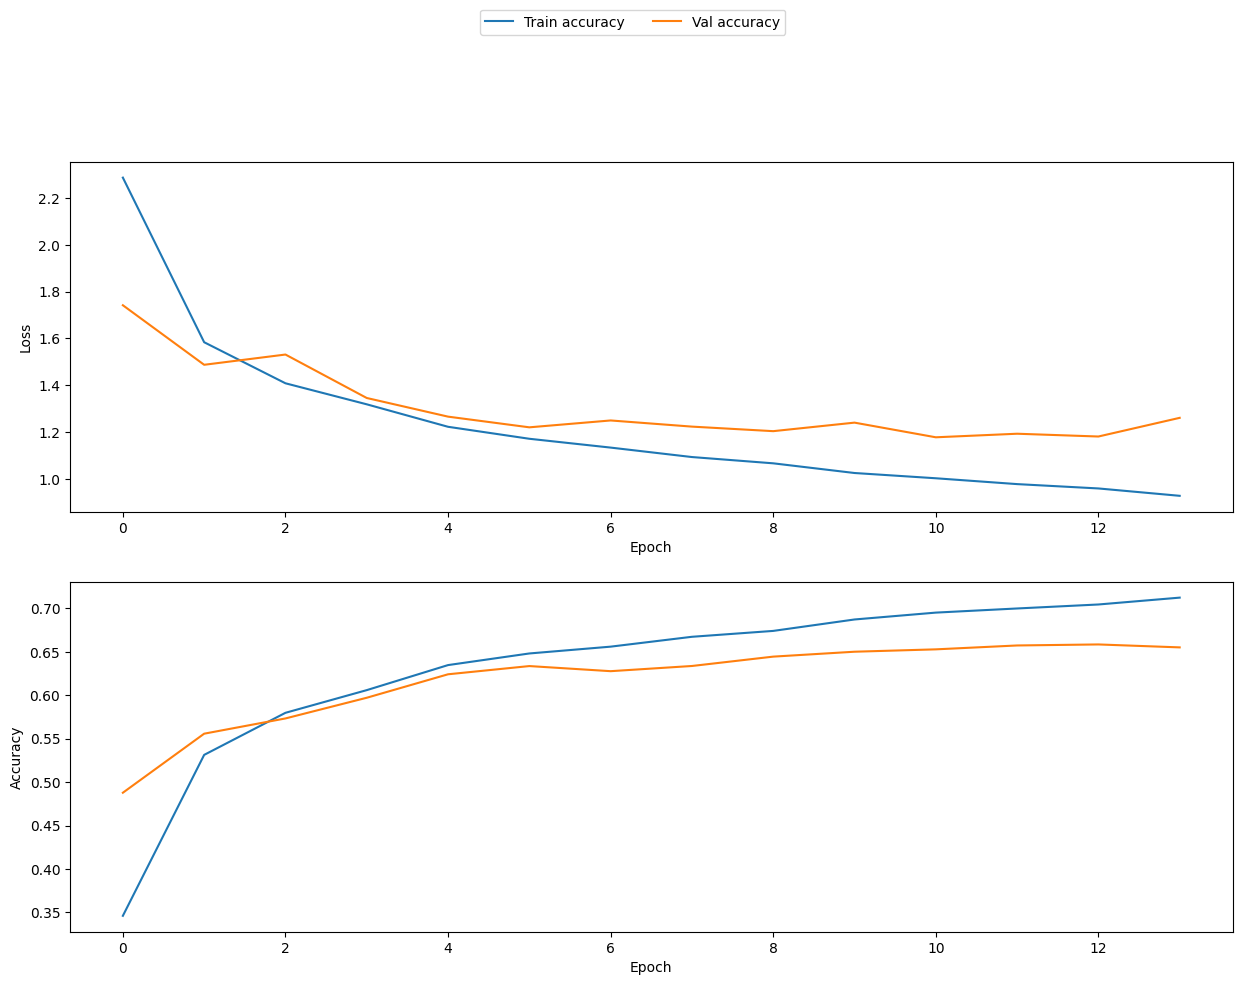

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_cnn_trad_fpool3.history['loss'], label='Train loss')
axis[0].plot(history_cnn_trad_fpool3.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_cnn_trad_fpool3.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_cnn_trad_fpool3.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

pred=cnn_trad_fpool3_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=(test_label_test).argmax(axis=1)

perform={}
perform["accuracy"]=[]
perform["balanced_accuracy"]=[]
perform["f1_score"]=[]
perform["precision_score"]=[]
perform["recall_score"]=[]
perform['model']=[]

perform['model'].append(f'{cnn_trad_fpool3_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score'].append(f1_score(true_pred, pred_class, average='weighted'))
perform['precision_score'].append(precision_score(true_pred, pred_class, average='macro'))
perform["recall_score"].append(recall_score(true_pred, pred_class, average='macro'))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)

166/166 [==============================] - 3s 20ms/step


In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score,precision_score,recall_score,model
0,0.648462,0.625874,0.649122,0.643447,0.625874,cnn_trad_fpool3_m


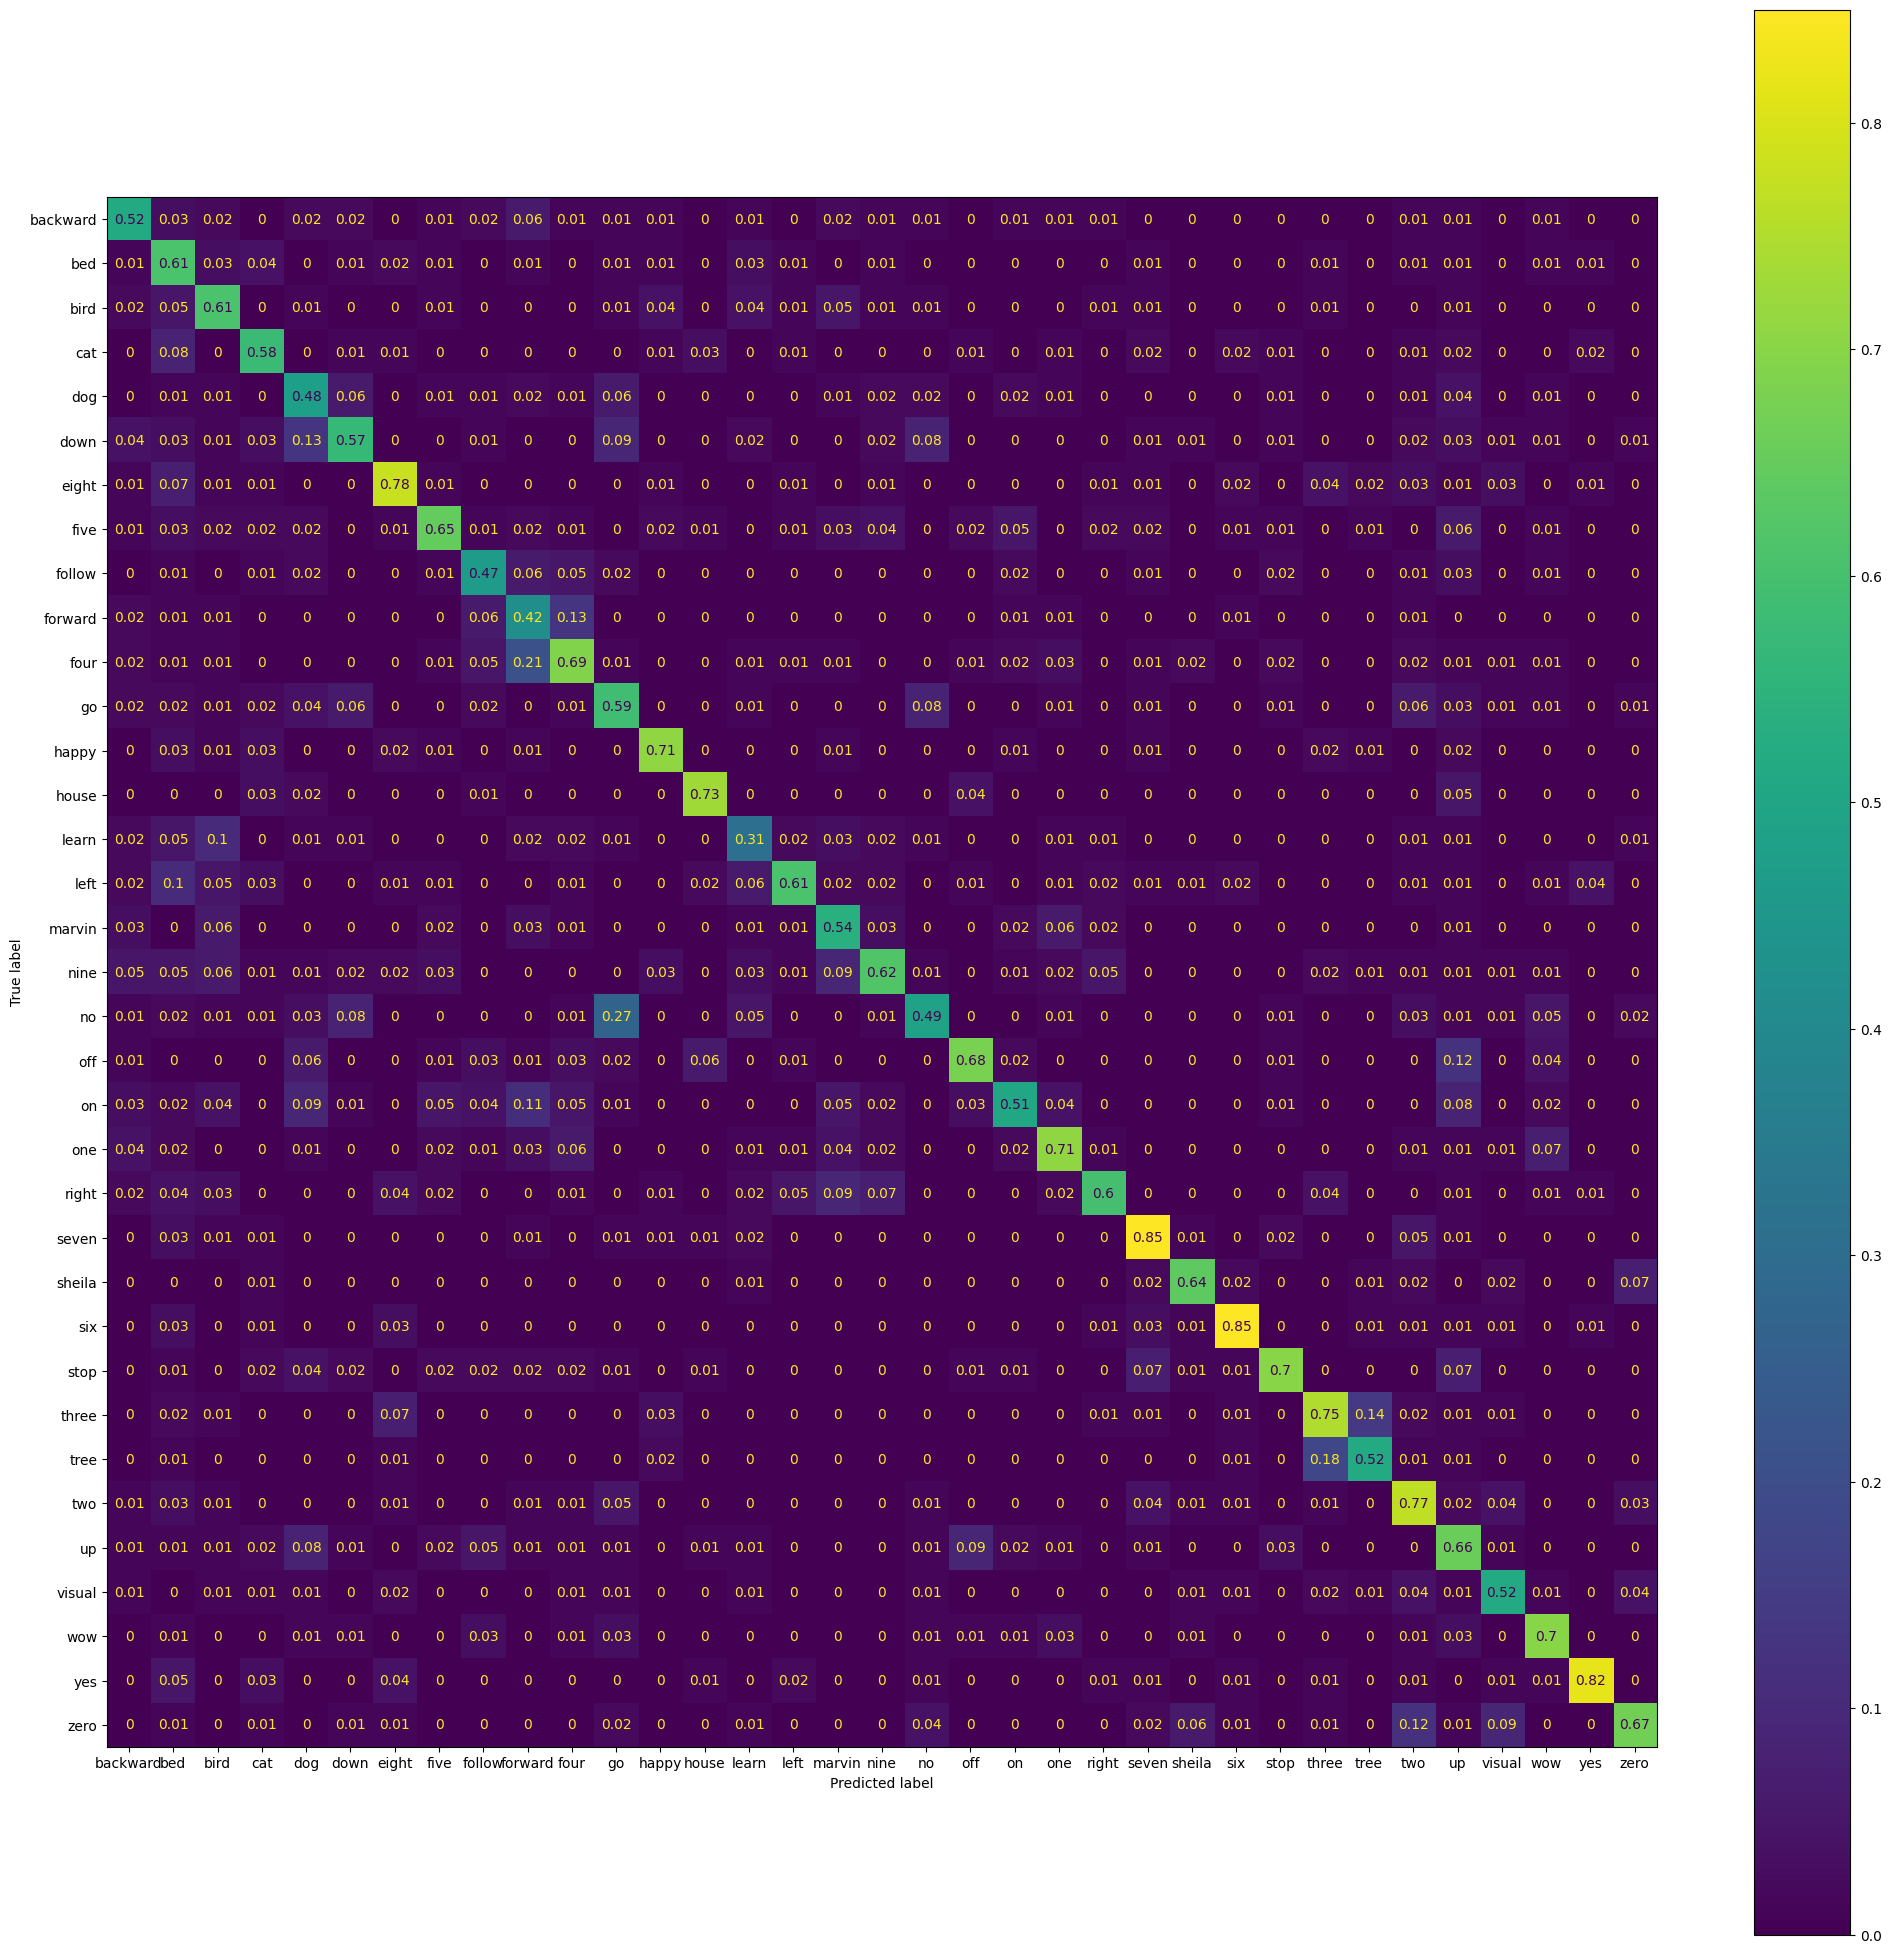

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

**Model trained with Log Filterbanks**

In [ ]:
df=pd.DataFrame([(k, i) for k, v in browse_directory().items() for i in v],columns=['key_id', 'ids'])

#train_mask, validation_mask = split(df, 0.6, 0.2)

#df.to_csv("content/drive/MyDrive/HDA/training_validation_test.csv")

train_mask=list(np.loadtxt("content/drive/MyDrive/HDA/training_mask.txt"))
validation_mask=list(np.loadtxt("content/drive/MyDrive/HDA/validation_mask.txt"))

batch_size=128
out_class=len(label_list)

train_set, train_set_label = create_dataset(df['ids'].iloc[train_mask], df['key_id'].iloc[train_mask], batch_size,shuffle=True, cache_file_value='train_cache', type='logfbank')
validation_set, validation_set_label = create_dataset(df['ids'].iloc[validation_mask], df['key_id'].iloc[validation_mask], batch_size, shuffle=True , cache_file_value='validation_cache', type='logfbank')
test_set, test_set_label = create_dataset(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)], df['key_id'].iloc[~df.index.isin(train_mask+validation_mask)], batch_size, cache_file_value='test_cache', shuffle=False  ,repeat=False, type='logfbank', testing=True)

train_steps = int(np.ceil(len(df['ids'].iloc[train_mask]) / batch_size))
validation_steps = int(np.ceil(len(df['ids'].iloc[validation_mask]) / batch_size))
test_steps = int(np.ceil(len(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)]) / batch_size))



Shuffled dataset
Shuffled dataset


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 99, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 40, 99, 64)        10304     
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 99, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 99, 64)        163904    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 99, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 82368)             0     

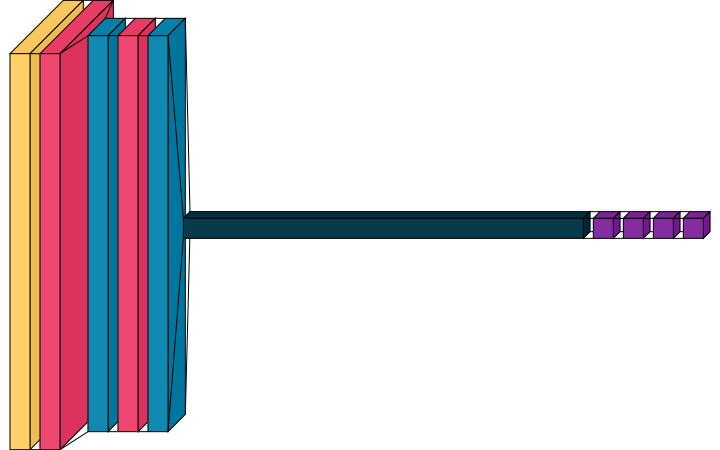

In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(40,99,1)

cnn_trad_fpool3_m = cnn_trad_fpool3(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(cnn_trad_fpool3_m.summary())
visualkeras.layered_view(cnn_trad_fpool3_m)

In [ ]:
cnn_trad_fpool3_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_cnn_trad_fpool3=cnn_trad_fpool3_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 364s 246ms/step - loss: 2.7486 - sparse_categorical_accuracy: 0.2197 - val_loss: 2.0596 - val_sparse_categorical_accuracy: 0.3795
Epoch 2/25
497/497 [==============================] - 49s 99ms/step - loss: 1.7765 - sparse_categorical_accuracy: 0.4629 - val_loss: 1.4507 - val_sparse_categorical_accuracy: 0.5626
Epoch 3/25
497/497 [==============================] - 43s 87ms/step - loss: 1.2292 - sparse_categorical_accuracy: 0.6255 - val_loss: 1.0962 - val_sparse_categorical_accuracy: 0.6649
Epoch 4/25
497/497 [==============================] - 43s 87ms/step - loss: 1.0341 - sparse_categorical_accuracy: 0.6833 - val_loss: 1.0046 - val_sparse_categorical_accuracy: 0.6935
Epoch 5/25
497/497 [==============================] - 44s 88ms/step - loss: 0.9357 - sparse_categorical_accuracy: 0.7122 - val_loss: 0.9218 - val_sparse_categorical_accuracy: 0.7200
Epoch 6/25
497/497 [==============================] - 48s 96ms/step - loss: 0.8846 - spa

In [ ]:
cnn_trad_fpool3_m.save("content/drive/MyDrive/HDA/models/logf_models/normal_dataset/{}".format('CRNNcnn_trad_fpool3_m_log_f'))
#CRNN_m=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/logf_models/normal_dataset/{}".format('CRNNcnn_trad_fpool3_m_log_f'))

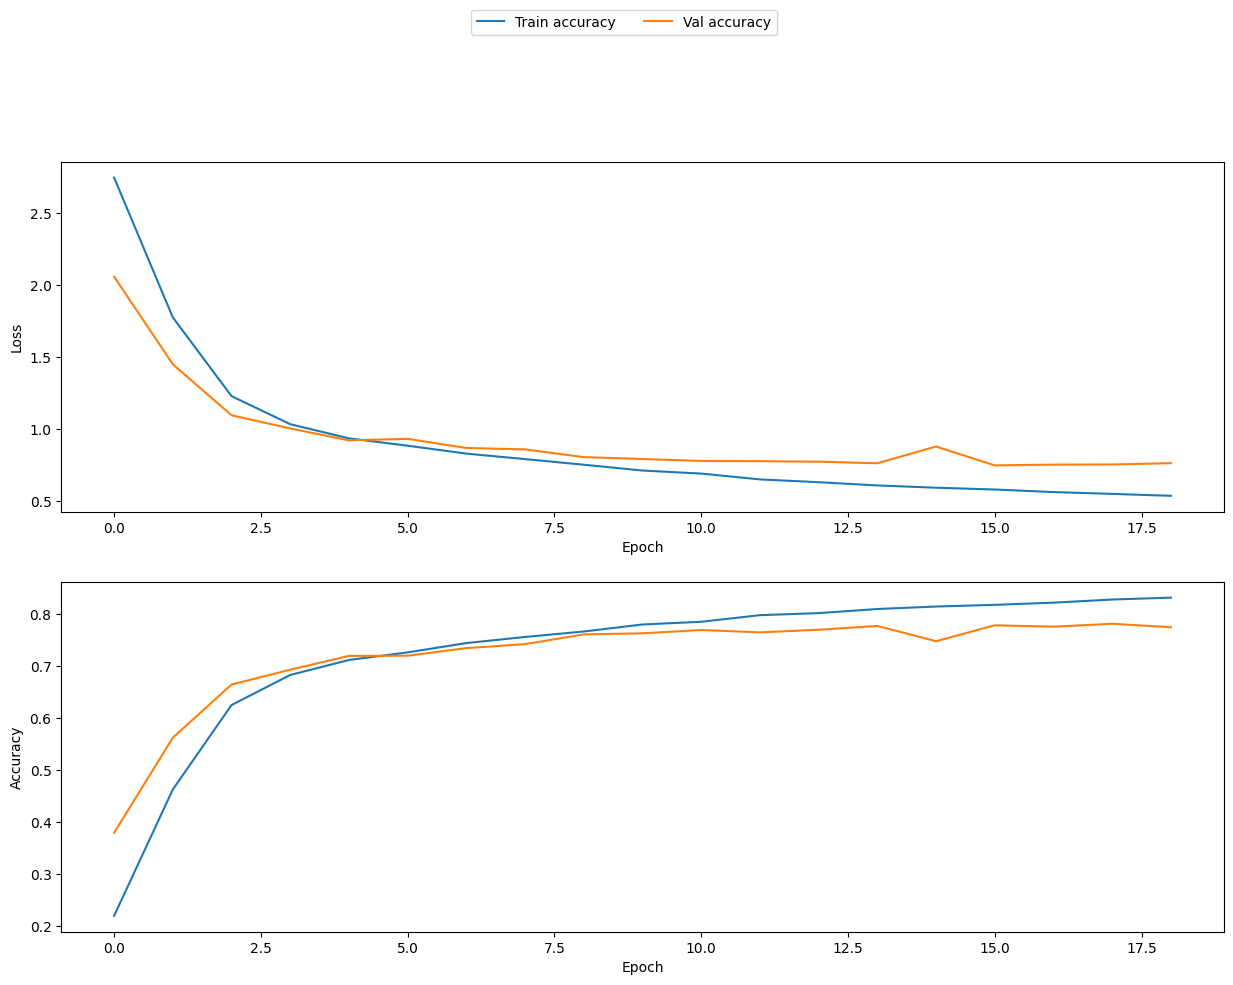

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_cnn_trad_fpool3.history['loss'], label='Train loss')
axis[0].plot(history_cnn_trad_fpool3.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_cnn_trad_fpool3.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_cnn_trad_fpool3.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score


perform={}

perform["accuracy"]=[]
perform["balanced_accuracy"]=[]

perform["f1_score_weighted"]=[]
perform["f1_score_micro"]=[]
perform["f1_score_macro"]=[]

perform["precision_score_weighted"]=[]
perform["precision_score_micro"]=[]
perform["precision_score_macro"]=[]

perform["recall_score_weighted"]=[]
perform["recall_score_micro"]=[]
perform["recall_score_macro"]=[]
perform['model']=[]

pred=cnn_trad_fpool3_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{cnn_trad_fpool3_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))


166/166 [==============================] - 95s 575ms/step


In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.776964,0.755885,0.776689,0.776964,0.760537,0.782253,0.776964,0.771504,0.776964,0.776964,0.755885,cnn_trad_fpool3_m


**Model trained with MFCC without deltas**

In [5]:
df=pd.DataFrame([(k, i) for k, v in browse_directory().items() for i in v],columns=['key_id', 'ids'])

#train_mask, validation_mask = split(df, 0.6, 0.2)

#df.to_csv("content/drive/MyDrive/HDA/training_validation_test.csv")

train_mask=list(np.loadtxt("content/drive/MyDrive/HDA/training_mask.txt"))
validation_mask=list(np.loadtxt("content/drive/MyDrive/HDA/validation_mask.txt"))

batch_size=128
out_class=len(label_list)

train_set, train_label_set = create_dataset(df['ids'].iloc[train_mask], df['key_id'].iloc[train_mask], batch_size,shuffle=True, cache_file_value='train_cache', type='mfcc',simple_mfcc=True)
validation_set, validation_label_set = create_dataset(df['ids'].iloc[validation_mask], df['key_id'].iloc[validation_mask], batch_size, shuffle=True , cache_file_value='validation_cache', type='mfcc',simple_mfcc=True)
test_set, test_label_test = create_dataset(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)], df['key_id'].iloc[~df.index.isin(train_mask+validation_mask)], batch_size, cache_file_value='test_cache', repeat=False, type='mfcc', testing=True,simple_mfcc=True)

train_steps = int(np.ceil(len(df['ids'].iloc[train_mask]) / batch_size))
validation_steps = int(np.ceil(len(df['ids'].iloc[validation_mask]) / batch_size))
test_steps = int(np.ceil(len(df['ids'].iloc[train_mask]) / batch_size))



Shuffled dataset
Shuffled dataset


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 99, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 13, 99, 64)        10304     
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 99, 64)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 99, 64)         163904    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 99, 64)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 25344)             0     

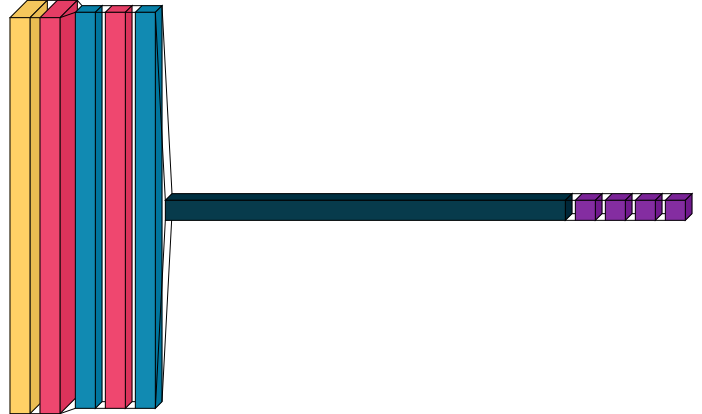

In [6]:
tf.config.run_functions_eagerly(True)

img_shape=(13,99,1)

cnn_trad_fpool3_m = cnn_trad_fpool3(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(cnn_trad_fpool3_m.summary())
visualkeras.layered_view(cnn_trad_fpool3_m)

In [7]:
cnn_trad_fpool3_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_cnn_trad_fpool3=cnn_trad_fpool3_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 423s 352ms/step - loss: 2.3826 - sparse_categorical_accuracy: 0.3079 - val_loss: 1.8539 - val_sparse_categorical_accuracy: 0.4429
Epoch 2/25
497/497 [==============================] - 34s 67ms/step - loss: 1.6820 - sparse_categorical_accuracy: 0.4893 - val_loss: 1.6089 - val_sparse_categorical_accuracy: 0.5163
Epoch 3/25
497/497 [==============================] - 36s 71ms/step - loss: 1.4599 - sparse_categorical_accuracy: 0.5535 - val_loss: 1.4439 - val_sparse_categorical_accuracy: 0.5631
Epoch 4/25
497/497 [==============================] - 34s 68ms/step - loss: 1.3573 - sparse_categorical_accuracy: 0.5852 - val_loss: 1.3203 - val_sparse_categorical_accuracy: 0.6003
Epoch 5/25
497/497 [==============================] - 36s 72ms/step - loss: 1.2707 - sparse_categorical_accuracy: 0.6102 - val_loss: 1.3239 - val_sparse_categorical_accuracy: 0.6020
Epoch 6/25
497/497 [==============================] - 35s 70ms/step - loss: 1.2214 - spa

In [8]:
cnn_trad_fpool3_m.save("content/drive/MyDrive/HDA/models/mfcc_uniq/normal_dataset/{}".format('cnn_trad_fpool3_mfcc_uniq'))
#base_CNN_trad_fpool3=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_uniq/normal_dataset/{}".format('cnn_trad_fpool3_mfcc_uniq'))

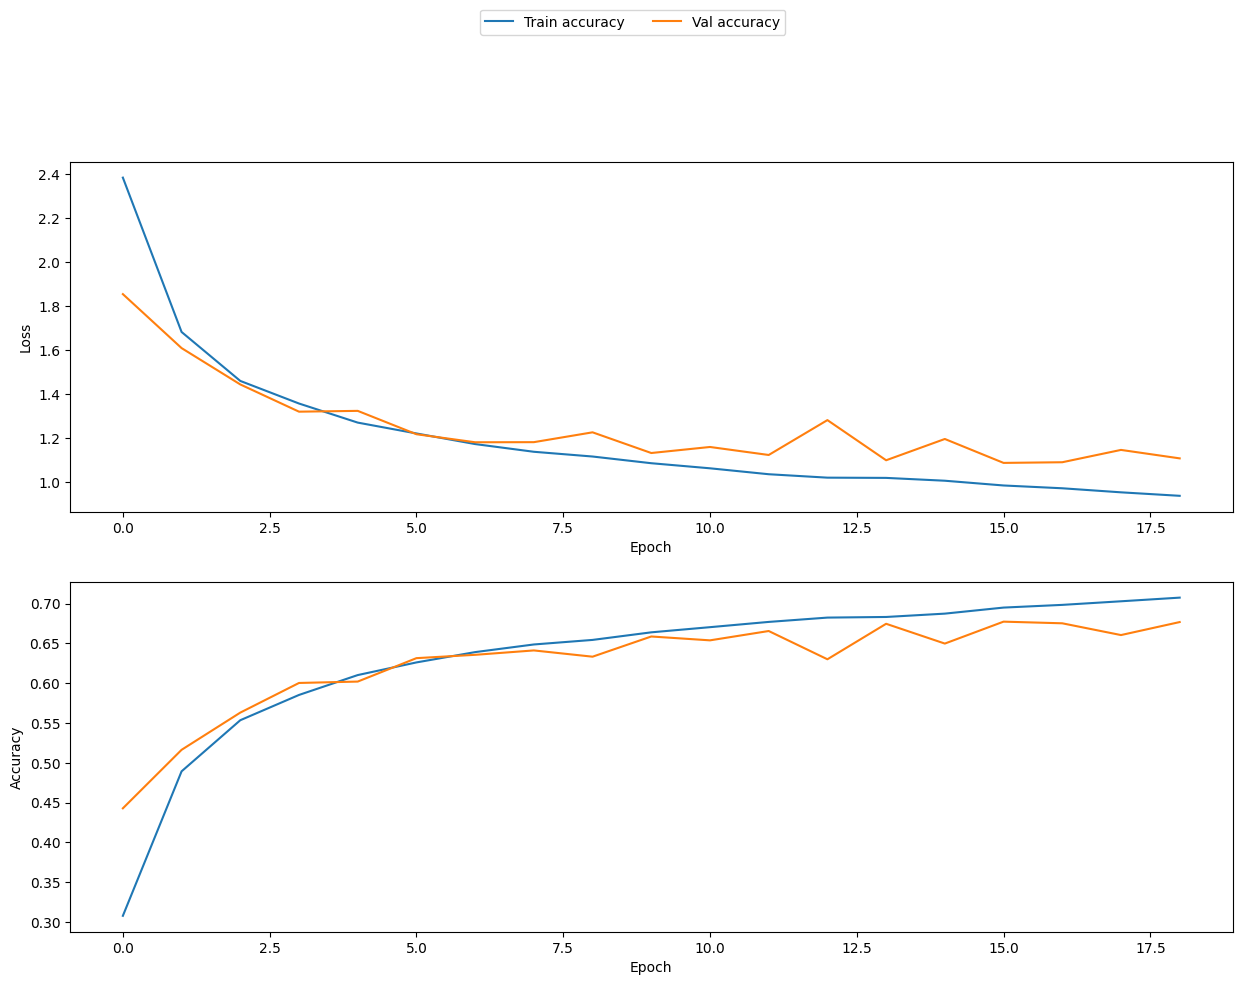

In [9]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_cnn_trad_fpool3.history['loss'], label='Train loss')
axis[0].plot(history_cnn_trad_fpool3.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_cnn_trad_fpool3.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_cnn_trad_fpool3.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [10]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score


perform={}

perform["accuracy"]=[]
perform["balanced_accuracy"]=[]

perform["f1_score_weighted"]=[]
perform["f1_score_micro"]=[]
perform["f1_score_macro"]=[]

perform["precision_score_weighted"]=[]
perform["precision_score_micro"]=[]
perform["precision_score_macro"]=[]

perform["recall_score_weighted"]=[]
perform["recall_score_micro"]=[]
perform["recall_score_macro"]=[]
perform['model']=[]

pred=cnn_trad_fpool3_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_label_test.argmax(axis=1)


perform['model'].append(f'{cnn_trad_fpool3_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))


166/166 [==============================] - 84s 506ms/step


In [11]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.665564,0.645299,0.66647,0.665564,0.647906,0.673413,0.665564,0.656075,0.665564,0.665564,0.645299,cnn_trad_fpool3_m


**Model trained with noised MFCC without deltas dataset**

In [5]:
df=pd.DataFrame([(k, i) for k, v in browse_directory().items() for i in v],columns=['key_id', 'ids'])

#train_mask, validation_mask = split(df, 0.6, 0.20)

train_mask=list(np.loadtxt("content/drive/MyDrive/HDA/training_mask.txt"))
validation_mask=list(np.loadtxt("content/drive/MyDrive/HDA/validation_mask.txt"))

batch_size=128
out_class=len(label_list)

train_set, train_set_label = create_dataset(df['ids'].iloc[train_mask], df['key_id'].iloc[train_mask], batch_size,shuffle=True, cache_file_value='train_cache', type='mfcc', input_noise=True, simple_mfcc=True)
validation_set, validation_set_label = create_dataset(df['ids'].iloc[validation_mask], df['key_id'].iloc[validation_mask], batch_size, shuffle=True , cache_file_value='validation_cache', type='mfcc',input_noise=True, simple_mfcc=True)
test_set, test_set_label = create_dataset(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)], df['key_id'].iloc[~df.index.isin(train_mask+validation_mask)], batch_size, cache_file_value='test_cache', shuffle=False  ,repeat=False, type='mfcc', testing=True,input_noise=True, simple_mfcc=True)

train_steps = int(np.ceil(len(df['ids'].iloc[train_mask]) / batch_size))
validation_steps = int(np.ceil(len(df['ids'].iloc[validation_mask]) / batch_size))
test_steps = int(np.ceil(len(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)]) / batch_size))



Shuffled dataset
Shuffled dataset


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 99, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 13, 99, 64)        10304     
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 99, 64)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 99, 64)         163904    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 99, 64)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 25344)             0     

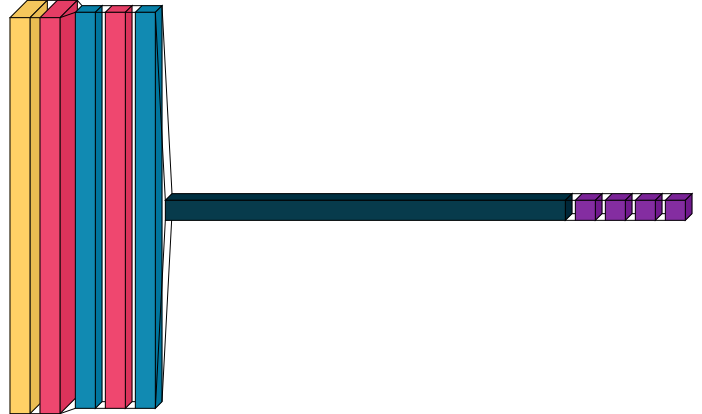

In [6]:
tf.config.run_functions_eagerly(True)

img_shape=(13,99,1)

cnn_trad_fpool3_m = cnn_trad_fpool3(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(cnn_trad_fpool3_m.summary())
visualkeras.layered_view(cnn_trad_fpool3_m)


In [7]:
cnn_trad_fpool3_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_cnn_trad_fpool3=cnn_trad_fpool3_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)



Epoch 1/25
497/497 [==============================] - 437s 345ms/step - loss: 2.5928 - sparse_categorical_accuracy: 0.2377 - val_loss: 2.1969 - val_sparse_categorical_accuracy: 0.3318
Epoch 2/25
497/497 [==============================] - 35s 70ms/step - loss: 1.9437 - sparse_categorical_accuracy: 0.4014 - val_loss: 1.8185 - val_sparse_categorical_accuracy: 0.4369
Epoch 3/25
497/497 [==============================] - 33s 67ms/step - loss: 1.7245 - sparse_categorical_accuracy: 0.4676 - val_loss: 1.6405 - val_sparse_categorical_accuracy: 0.4917
Epoch 4/25
497/497 [==============================] - 33s 66ms/step - loss: 1.6013 - sparse_categorical_accuracy: 0.5041 - val_loss: 1.5583 - val_sparse_categorical_accuracy: 0.5144
Epoch 5/25
497/497 [==============================] - 33s 67ms/step - loss: 1.4867 - sparse_categorical_accuracy: 0.5389 - val_loss: 1.4595 - val_sparse_categorical_accuracy: 0.5473
Epoch 6/25
497/497 [==============================] - 33s 66ms/step - loss: 1.4157 - spa

In [8]:
cnn_trad_fpool3_m.save("content/drive/MyDrive/HDA/models/mfcc_uniq/noisy_dataset/{}".format('cnn_trad_fpool3_mfcc_uniq_noisy'))
#base_CNN_trad_fpool3=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_uniq/noisy_dataset/{}".format('cnn_trad_fpool3_mfcc_uniq_noisy'))


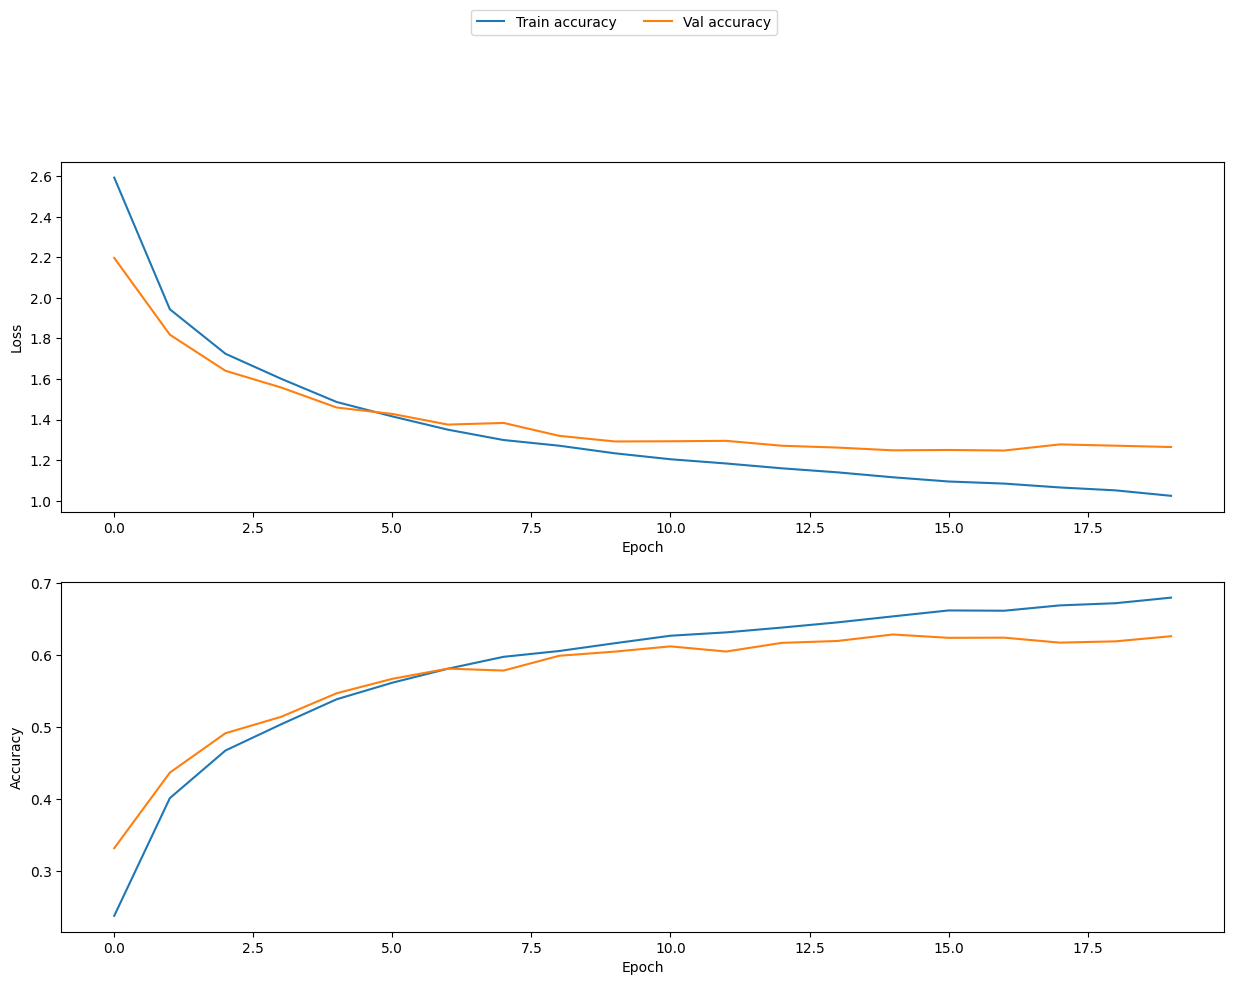

In [9]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_cnn_trad_fpool3.history['loss'], label='Train loss')
axis[0].plot(history_cnn_trad_fpool3.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_cnn_trad_fpool3.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_cnn_trad_fpool3.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()

In [10]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

pred=cnn_trad_fpool3_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=(test_set_label).argmax(axis=1)

perform={}
perform["accuracy"]=[]
perform["balanced_accuracy"]=[]
perform["f1_score"]=[]
perform["precision_score"]=[]
perform["recall_score"]=[]
perform['model']=[]

perform['model'].append(f'{cnn_trad_fpool3_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score'].append(f1_score(true_pred, pred_class, average='weighted'))
perform['precision_score'].append(precision_score(true_pred, pred_class, average='macro'))
perform["recall_score"].append(recall_score(true_pred, pred_class, average='macro'))



166/166 [==============================] - 94s 567ms/step


In [11]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score,precision_score,recall_score,model
0,0.625691,0.60263,0.623939,0.614792,0.60263,cnn_trad_fpool3_m


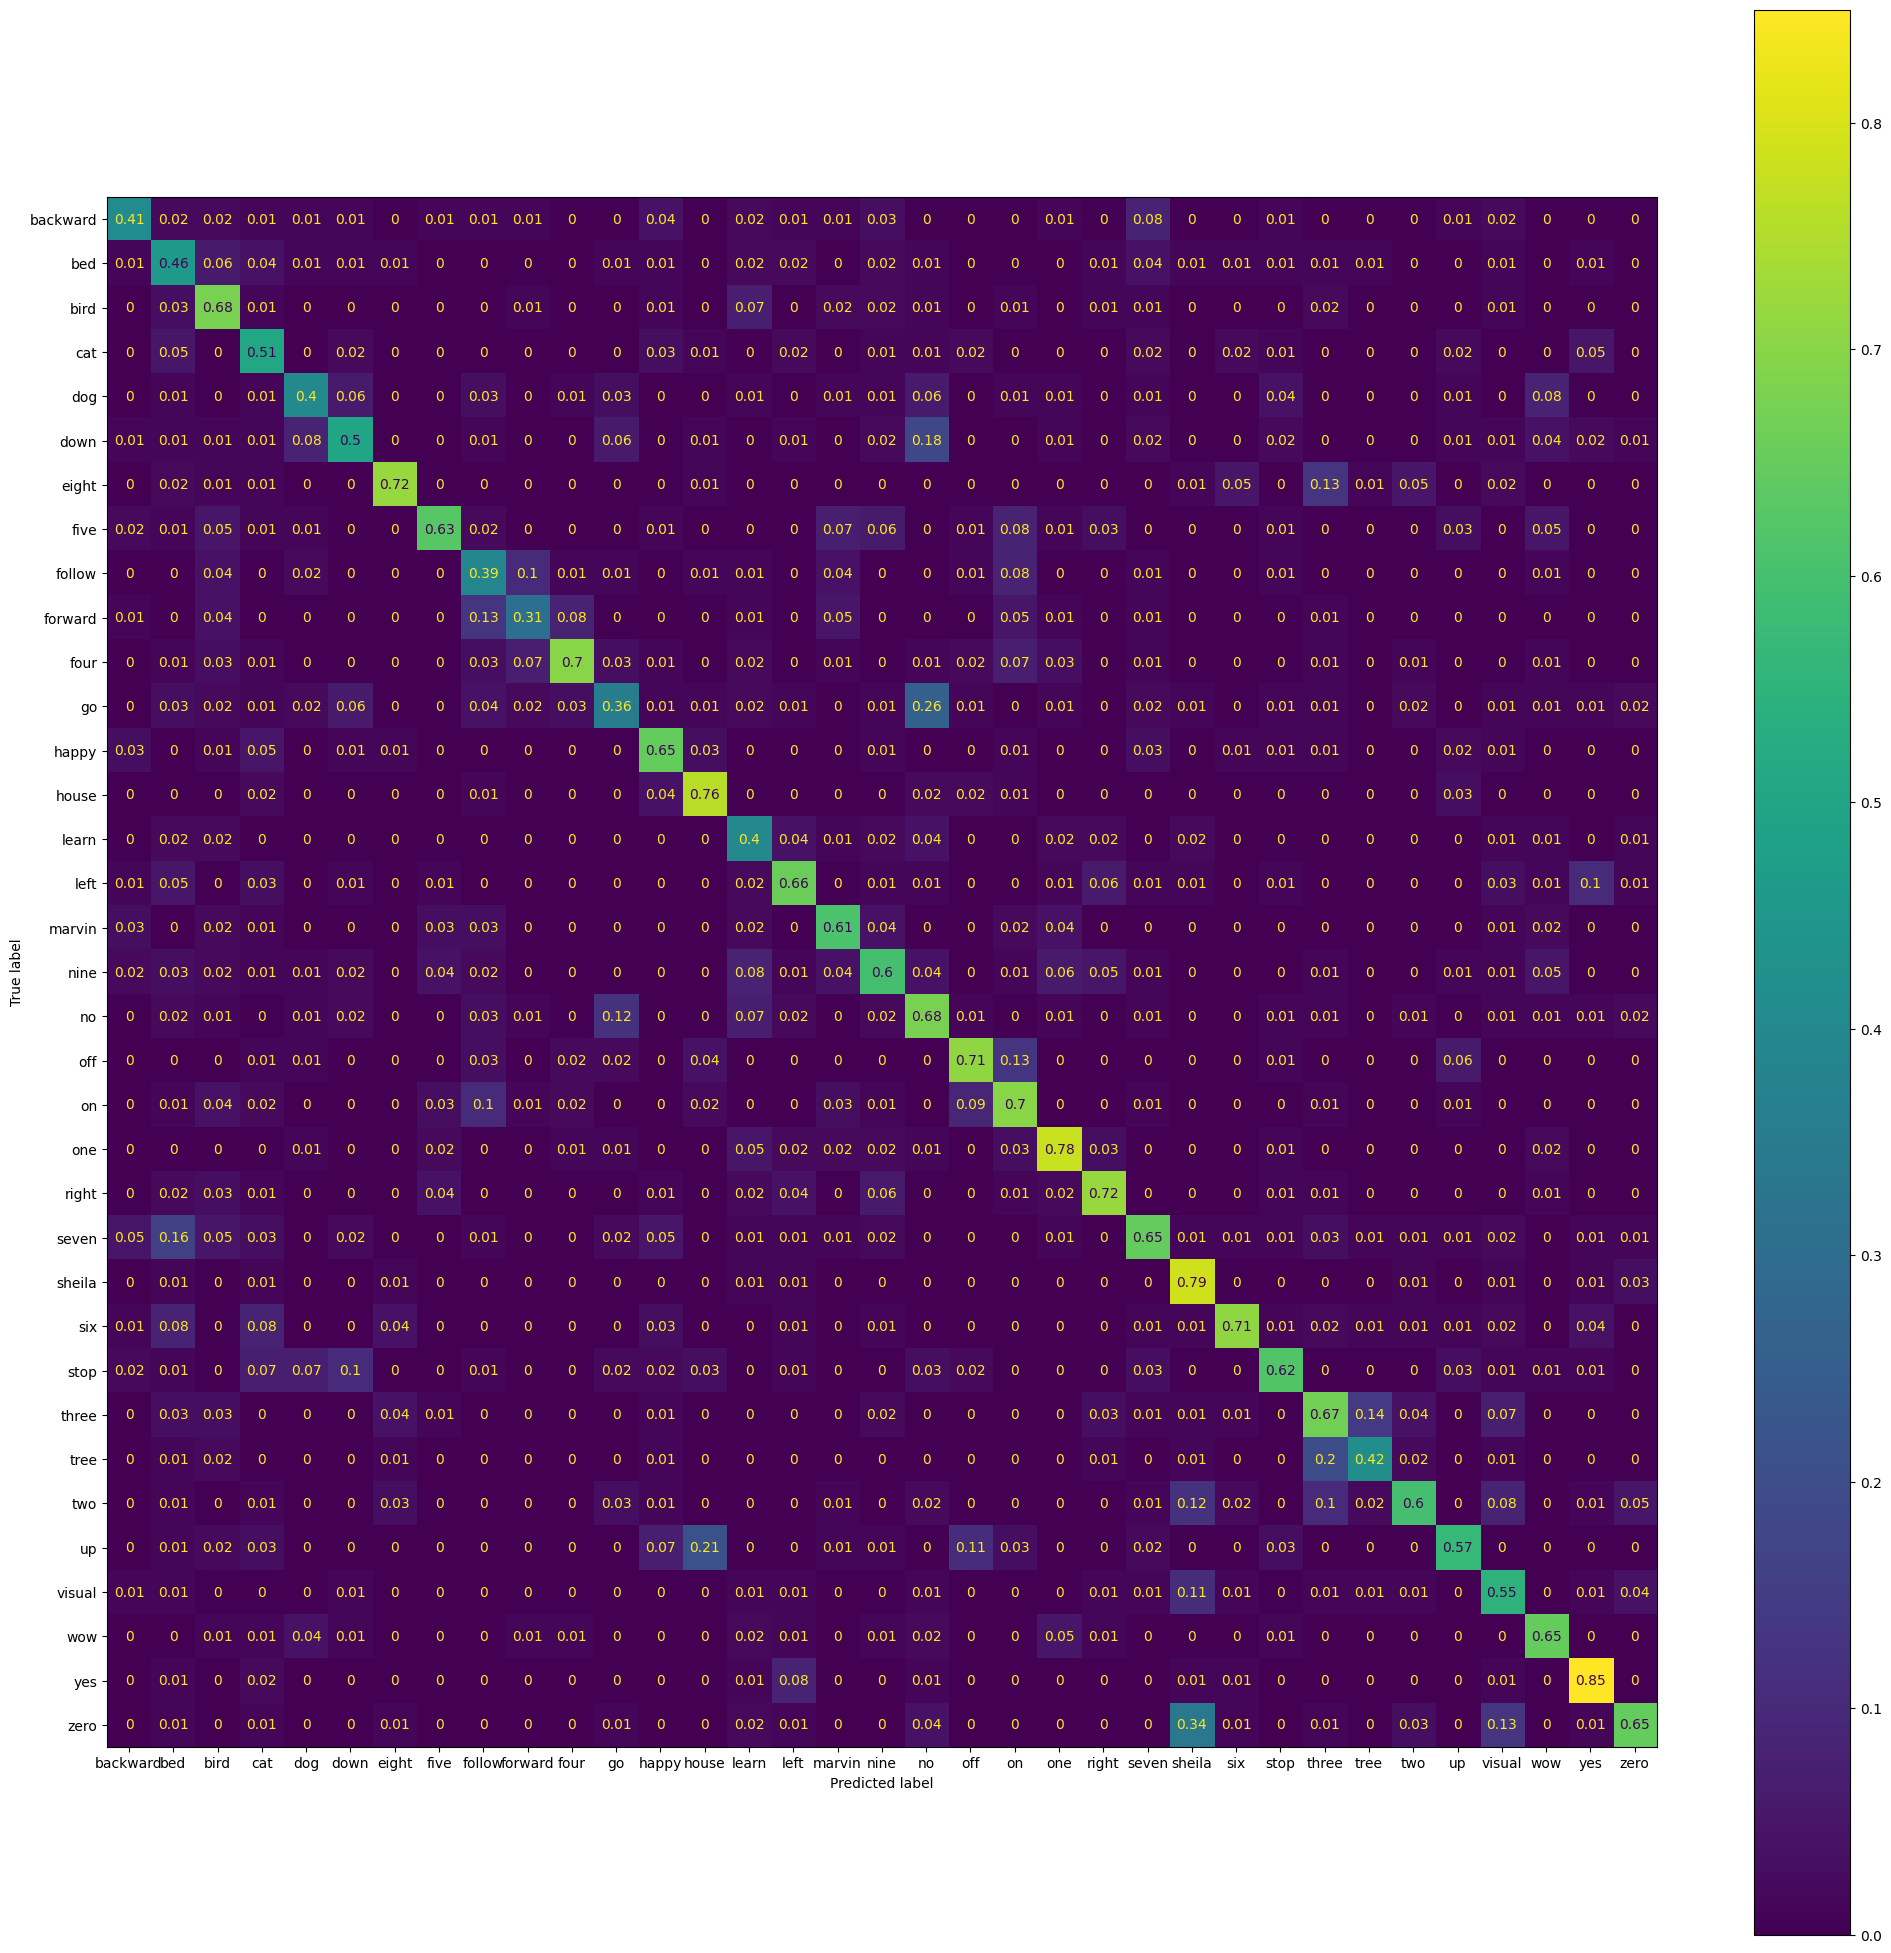

In [12]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

**Model trained with MFCC noised dataset**

In [5]:
df=pd.DataFrame([(k, i) for k, v in browse_directory().items() for i in v],columns=['key_id', 'ids'])

#train_mask, validation_mask = split(df, 0.6, 0.20)

train_mask=list(np.loadtxt("content/drive/MyDrive/HDA/training_mask.txt"))
validation_mask=list(np.loadtxt("content/drive/MyDrive/HDA/validation_mask.txt"))

batch_size=128
out_class=len(label_list)

train_set, train_set_label = create_dataset(df['ids'].iloc[train_mask], df['key_id'].iloc[train_mask], batch_size,shuffle=True, cache_file_value='train_cache', type='mfcc', input_noise=True)
validation_set, validation_set_label = create_dataset(df['ids'].iloc[validation_mask], df['key_id'].iloc[validation_mask], batch_size, shuffle=True , cache_file_value='validation_cache', type='mfcc',input_noise=True)
test_set, test_set_label = create_dataset(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)], df['key_id'].iloc[~df.index.isin(train_mask+validation_mask)], batch_size, cache_file_value='test_cache', shuffle=False  ,repeat=False, type='mfcc', testing=True,input_noise=True)

train_steps = int(np.ceil(len(df['ids'].iloc[train_mask]) / batch_size))
validation_steps = int(np.ceil(len(df['ids'].iloc[validation_mask]) / batch_size))
test_steps = int(np.ceil(len(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)]) / batch_size))



Shuffled dataset
Shuffled dataset


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 39, 99, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 39, 99, 64)        10304     
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 99, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 99, 64)        163904    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 99, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 82368)             0     

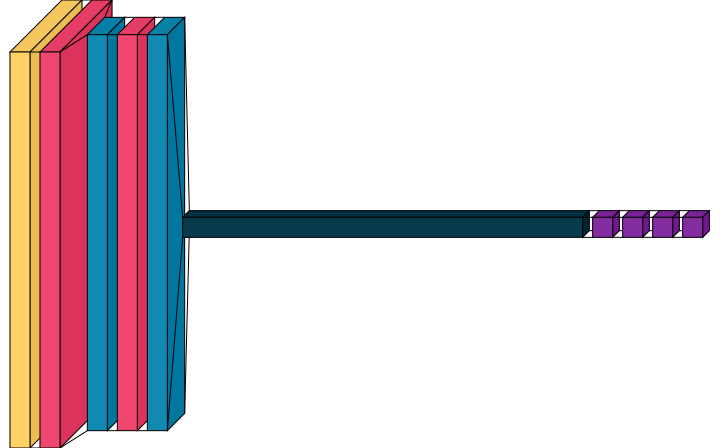

In [6]:
tf.config.run_functions_eagerly(True)

img_shape=(39,99,1)

cnn_trad_fpool3_m = cnn_trad_fpool3(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(cnn_trad_fpool3_m.summary())
visualkeras.layered_view(cnn_trad_fpool3_m)


In [7]:
cnn_trad_fpool3_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_cnn_trad_fpool3=cnn_trad_fpool3_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)



Epoch 1/25
497/497 [==============================] - 549s 370ms/step - loss: 2.9676 - sparse_categorical_accuracy: 0.1515 - val_loss: 2.4764 - val_sparse_categorical_accuracy: 0.2597
Epoch 2/25
497/497 [==============================] - 46s 93ms/step - loss: 2.2470 - sparse_categorical_accuracy: 0.3143 - val_loss: 2.0599 - val_sparse_categorical_accuracy: 0.3695
Epoch 3/25
497/497 [==============================] - 45s 91ms/step - loss: 1.9028 - sparse_categorical_accuracy: 0.4156 - val_loss: 1.8545 - val_sparse_categorical_accuracy: 0.4316
Epoch 4/25
497/497 [==============================] - 50s 101ms/step - loss: 1.7277 - sparse_categorical_accuracy: 0.4698 - val_loss: 1.6653 - val_sparse_categorical_accuracy: 0.4864
Epoch 5/25
497/497 [==============================] - 45s 91ms/step - loss: 1.6255 - sparse_categorical_accuracy: 0.5028 - val_loss: 1.6108 - val_sparse_categorical_accuracy: 0.5040
Epoch 6/25
497/497 [==============================] - 45s 91ms/step - loss: 1.5524 - sp

In [9]:
cnn_trad_fpool3_m.save("content/drive/MyDrive/HDA/models/mfcc_models/noisy_dataset/{}".format('cnn_trad_fpool3_mfcc_noisy'))
#cnn_trad_fpool3_m=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/mfcc_models/noisy_dataset/{}".format('cnn_trad_fpool3_mfcc_noisy'))


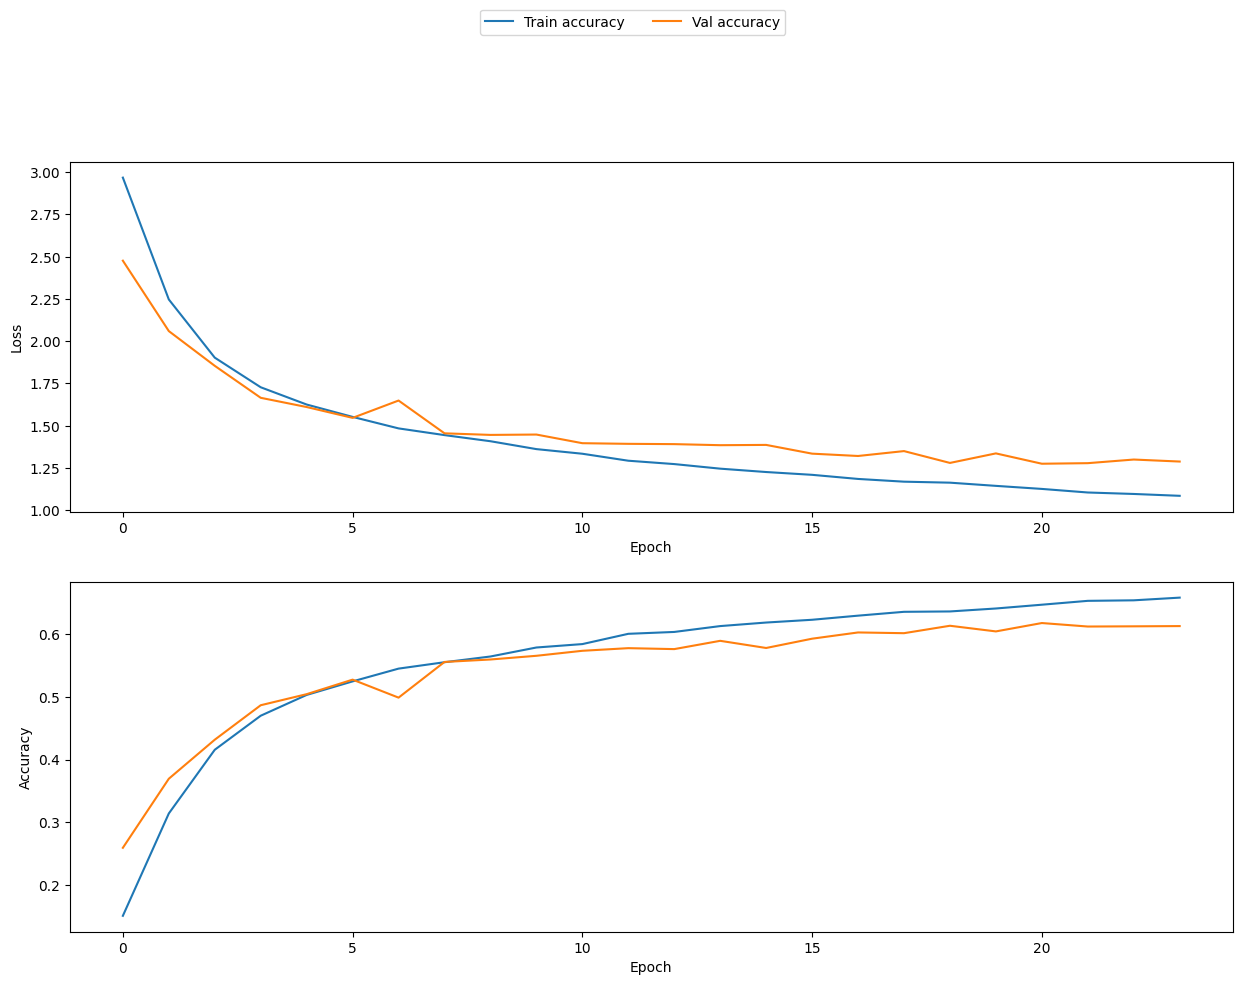

In [10]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_cnn_trad_fpool3.history['loss'], label='Train loss')
axis[0].plot(history_cnn_trad_fpool3.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_cnn_trad_fpool3.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_cnn_trad_fpool3.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()

In [11]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

pred=cnn_trad_fpool3_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=(test_set_label).argmax(axis=1)

perform={}
perform["accuracy"]=[]
perform["balanced_accuracy"]=[]
perform["f1_score"]=[]
perform["precision_score"]=[]
perform["recall_score"]=[]
perform['model']=[]

perform['model'].append(f'{cnn_trad_fpool3_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score'].append(f1_score(true_pred, pred_class, average='weighted'))
perform['precision_score'].append(precision_score(true_pred, pred_class, average='macro'))
perform["recall_score"].append(recall_score(true_pred, pred_class, average='macro'))



166/166 [==============================] - 113s 682ms/step


In [12]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score,precision_score,recall_score,model
0,0.615297,0.589108,0.612304,0.608414,0.589108,cnn_trad_fpool3_m


**Model trained on log Filterbank  noised dataset**

In [5]:
df=pd.DataFrame([(k, i) for k, v in browse_directory().items() for i in v],columns=['key_id', 'ids'])

#train_mask, validation_mask = split(df, 0.6, 0.20)

train_mask=list(np.loadtxt("content/drive/MyDrive/HDA/training_mask.txt"))
validation_mask=list(np.loadtxt("content/drive/MyDrive/HDA/validation_mask.txt"))

batch_size=128
out_class=len(label_list)

train_set, train_set_label = create_dataset(df['ids'].iloc[train_mask], df['key_id'].iloc[train_mask], batch_size,shuffle=True, cache_file_value='train_cache', type='logfbank', input_noise=True)
validation_set, validation_set_label = create_dataset(df['ids'].iloc[validation_mask], df['key_id'].iloc[validation_mask], batch_size, shuffle=True , cache_file_value='validation_cache', type='logfbank',input_noise=True)
test_set, test_set_label = create_dataset(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)], df['key_id'].iloc[~df.index.isin(train_mask+validation_mask)], batch_size, cache_file_value='test_cache', shuffle=False  ,repeat=False, type='logfbank', testing=True,input_noise=True)

train_steps = int(np.ceil(len(df['ids'].iloc[train_mask]) / batch_size))
validation_steps = int(np.ceil(len(df['ids'].iloc[validation_mask]) / batch_size))
test_steps = int(np.ceil(len(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)]) / batch_size))



Shuffled dataset
Shuffled dataset


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 99, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 40, 99, 64)        10304     
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 99, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 99, 64)        163904    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 99, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 82368)             0     

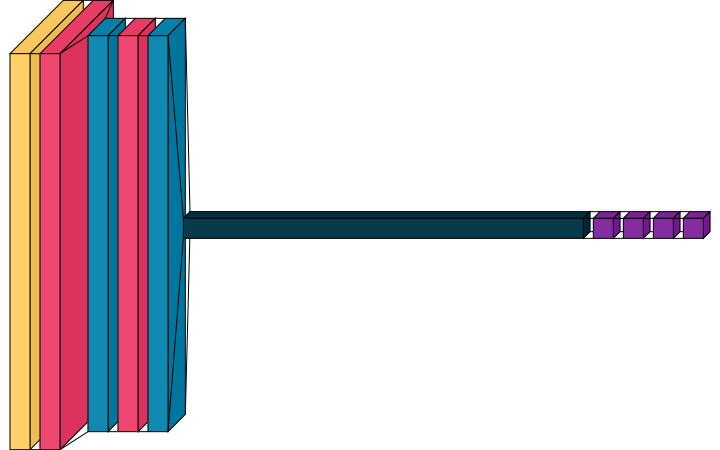

In [6]:
tf.config.run_functions_eagerly(True)

img_shape=(40,99,1)

cnn_trad_fpool3_m = cnn_trad_fpool3(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(cnn_trad_fpool3_m.summary())
visualkeras.layered_view(cnn_trad_fpool3_m)


In [7]:
cnn_trad_fpool3_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_cnn_trad_fpool3=cnn_trad_fpool3_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)



Epoch 1/25
497/497 [==============================] - 416s 270ms/step - loss: 2.9311 - sparse_categorical_accuracy: 0.1696 - val_loss: 2.3170 - val_sparse_categorical_accuracy: 0.3037
Epoch 2/25
497/497 [==============================] - 46s 92ms/step - loss: 1.9821 - sparse_categorical_accuracy: 0.4030 - val_loss: 1.7602 - val_sparse_categorical_accuracy: 0.4623
Epoch 3/25
497/497 [==============================] - 45s 91ms/step - loss: 1.5382 - sparse_categorical_accuracy: 0.5304 - val_loss: 1.4398 - val_sparse_categorical_accuracy: 0.5610
Epoch 4/25
497/497 [==============================] - 45s 90ms/step - loss: 1.3544 - sparse_categorical_accuracy: 0.5820 - val_loss: 1.3477 - val_sparse_categorical_accuracy: 0.5881
Epoch 5/25
497/497 [==============================] - 50s 101ms/step - loss: 1.2456 - sparse_categorical_accuracy: 0.6115 - val_loss: 1.3289 - val_sparse_categorical_accuracy: 0.5918
Epoch 6/25
497/497 [==============================] - 45s 90ms/step - loss: 1.1731 - sp

In [8]:
cnn_trad_fpool3_m.save("content/drive/MyDrive/HDA/models/logf_models/noisy_dataset/{}".format('cnn_trad_fpool3_logf_noisy'))
#base_CNN_trad_fpool3=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/{}".format('cnn_fstride8'))

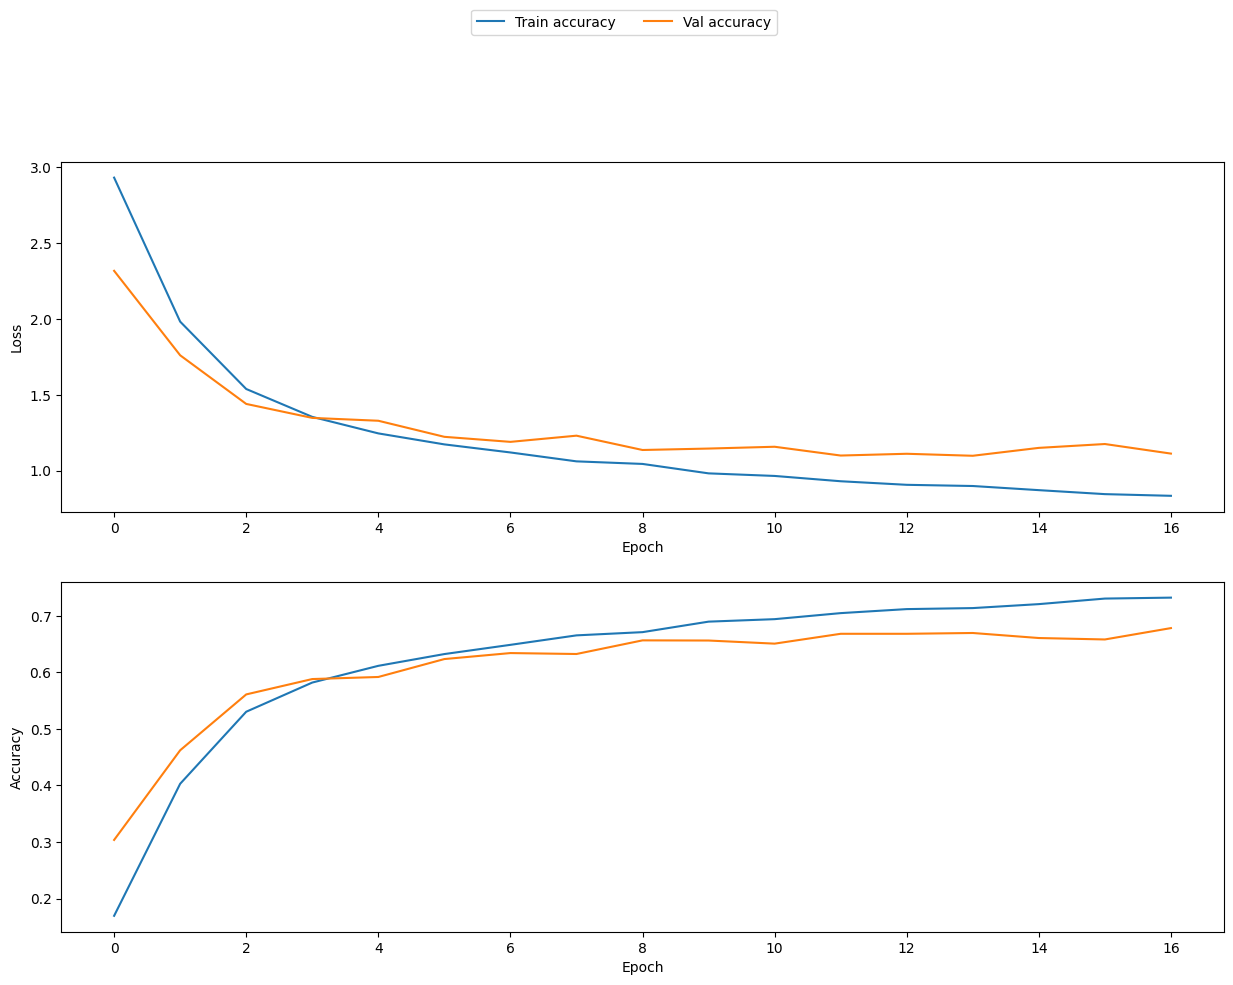

In [9]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_cnn_trad_fpool3.history['loss'], label='Train loss')
axis[0].plot(history_cnn_trad_fpool3.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_cnn_trad_fpool3.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_cnn_trad_fpool3.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()

In [10]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

pred=cnn_trad_fpool3_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=(test_set_label).argmax(axis=1)

perform={}
perform["accuracy"]=[]
perform["balanced_accuracy"]=[]
perform["f1_score"]=[]
perform["precision_score"]=[]
perform["recall_score"]=[]
perform['model']=[]

perform['model'].append(f'{cnn_trad_fpool3_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score'].append(f1_score(true_pred, pred_class, average='weighted'))
perform['precision_score'].append(precision_score(true_pred, pred_class, average='macro'))
perform["recall_score"].append(recall_score(true_pred, pred_class, average='macro'))



166/166 [==============================] - 94s 567ms/step


In [11]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score,precision_score,recall_score,model
0,0.669769,0.650093,0.669676,0.664266,0.650093,cnn_trad_fpool3_m
